# Set Up

In [1]:
# Mount Google Drive
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os
import pandas as pd
import math
import numpy as np
!pip install tweet-preprocessor

# Data

For our training, we have a few corpora to work with.

1. the [QIAN](https://github.com/jing-qian/A-Benchmark-Dataset-for-Learning-to-Intervene-in-Online-Hate-Speech) Benchmark dataset
2. the [CONAN](https://github.com/marcoguerini/CONAN) datasets
3. the [CrowdCounter](https://github.com/hate-alert/CrowdCounter/tree/main) Benchmark dataset
4. the [EDOS](https://github.com/rewire-online/edos) explainable detection of online sexism challenge dataset
5. the [SBIC](https://maartensap.com/social-bias-frames/) social bias frame dataset

First we set the path to our downloaded corpora

---



In [3]:
# set data paths
root_dir = "gdrive/My Drive/Master_Thesis/"
data_dir = os.path.join(root_dir, 'data/')

# Qian Benchmark Datasets
Qian_gab_dir = os.path.join(data_dir, 'Qian/gab.csv')
Qian_reddit_dir = os.path.join(data_dir, 'Qian/reddit.csv')

# CONAN datasets
CONAN_dir = os.path.join(data_dir, 'CONAN/CONAN.csv')
Multitarget_CONAN_dir = os.path.join(data_dir, 'Multitarget-CONAN/Multitarget-CONAN.csv')
DIALO_CONAN_dir = os.path.join(data_dir, 'DIALOCONAN/DIALOCONAN.csv')
KN_CONAN_dir = os.path.join(data_dir, 'multitarget_KN_grounded_CN/multitarget_KN_grounded_CN.csv')

# CrowdCounter Benchmark (from HateXplain)
CrowdCounter_dir = os.path.join(data_dir, 'CrowdCounter/Final_Dataset_additional_context.json')

# EDOS explainable Hate challenge dataset
EDOS_dir = os.path.join(data_dir, 'EDOS/edos_labelled_aggregated.csv')

# SBIC social bias frame dataset
SBIC_train_dir = os.path.join(data_dir, 'SBIC/SBIC.v2.agg.trn.csv')
SBIC_val_dir = os.path.join(data_dir, 'SBIC/SBIC.v2.agg.dev.csv')
SBIC_test_dir = os.path.join(data_dir, 'SBIC/SBIC.v2.agg.tst.csv')

## Data Formating
---

<br>

For fine-tuning GPT models (Causal Language Modeling), we concatenate the hate speech and the counter speech in one string with each begins with their prefix:

### **Hate-speech: I hate someone Counter-speech: Don't hate**    
<br>

---

<br>

In order to process instances from different corpora, we first convert everything into the same format of:

**"Hate_Speech": hate_speech**

**"Counter_Speech": counter_speech**

**"Target": target**

<br>

---

We currently include 8 target groups:

In [4]:
types = ["MIGRANTS", "POC", "LGBT+", "MUSLIMS", "WOMEN", "JEWS", "other", "DISABLED"]

### Qian Benchmark Dataset
This dataset contains multiturn conversations and hate speech index, which indecate the hate speech segment inside the conversation, and the corresponding 3 response options.

For data cleaning, we first want to seperate the conversations into individual segments, and the responses into individual response.

Then, we take the hate-speech and response pair and concatenate them according to our defined data format.

Since there can be multiple hate-speech inside one conversation, and the dataset provides multiple responses for each conversation, we use combinatorial pairs to capture all possible combinations.

-

---

currently, this dataset is causing the model to perform in an undesired way. Therefore, we are not including it in our training and testing pipeline.

---



In [5]:
def Qian_preprocess(dataframe):
  # Some general preprocessing at first
  df = dataframe.copy()

  # Remove unwanted information
  df = df.drop("id", axis=1)

  # drop rows without hate speech
  df = df[df['hate_speech_idx'].notna()].reset_index()

  # remove square brackets
  df['hate_speech_idx'] = df['hate_speech_idx'].str.strip('[]')
  df['response'] = df['response'].str.strip('[]')

  # drop old index
  df = df.drop("index", axis=1)

  # split conversation segments into individual strings
  df['text'] = df['text'].str.split('\n')

  # split responses into individual strings
  df['response'] = df['response'].str.split(',')

  # split hate speech index into individual strings
  df['hate_speech_idx'] = df['hate_speech_idx'].str.split(',')

  return df

def Qian_clean(list_):
  # Text cleaning function, removes URLs, EMOJIs and extra whitespaces or special characters
  for idx, text in enumerate(list_):
    # pop element if it's empty (due to spliting with ",")
    if text == "":
      list_.pop()
    else:
      # remove the numbering, which are the first three characters
      list_[idx] = text[3:]


  return list_

def Qian_concatenate(df):
  # Create new dataframe with format "Hate-speech: "hatespeech text" Counter-speech: "counterspeech text", for each hate- and counter-speech pair
  n_entry = df.index.stop
  HATE_SPEECH = []
  COUNTER_SPEECH = []

  # go through each row in dataframe and check the number of hate speech and responses
  for idx in range(n_entry):
    # for each hate speech, concatenate each response as a pair
    for i, hate_idx in enumerate(df["hate_speech_idx"][idx]):
      if len(df["text"][idx]) < int(hate_idx):
        # Skip if the hate_speech_idx is wrong (outside of the given conversation, e.g. there're in total 14 segments, but the hate_idx is 20)
        pass

      else:
        hate_speech = df['text'][idx][int(hate_idx) - 1]
        for j, response in enumerate(df["response"][idx]):
          HATE_SPEECH.append(hate_speech)
          COUNTER_SPEECH.append(response)

  dic = {'Hate_Speech': HATE_SPEECH, 'Counter_Speech': COUNTER_SPEECH}
  df_new = pd.DataFrame(dic)

  return df_new

def Qian_pipeline(df_raw):
  df = Qian_preprocess(df_raw)
  df["text"].map(Qian_clean)
  df = Qian_concatenate(df)

  return df

In [6]:
raw_Qian_gab = pd.read_csv(Qian_gab_dir)
raw_Qian_reddit = pd.read_csv(Qian_reddit_dir)

In [7]:
df_Qian_gab = Qian_pipeline(raw_Qian_gab)
df_Qian_reddit = Qian_pipeline(raw_Qian_reddit)

In [8]:
df_Qian_gab

,Hate_Speech,Counter_Speech
0,i joined gab to remind myself how retarded jew...,"""Using words that insult one group while defen..."
1,i joined gab to remind myself how retarded jew...,'You can make the same point more effectively...
2,i joined gab to remind myself how retarded jew...,'Use of the r-word is unacceptable in our dis...
3,\t\tDumb Cunt,'You can disagree with someones opinion withou...
4,\t\tDumb Cunt,'You can make the same point more effectively...
...,...,...
54434,How absolutely unbelievably fascinating? A Pak...,"""Using words that derogatorily reference a par..."
54435,How absolutely unbelievably fascinating? A Pak...,'Hey there
54436,How absolutely unbelievably fascinating? A Pak...,sexist comments and views are rude and unwelc...
54437,How absolutely unbelievably fascinating? A Pak...,'Instead of just stating your opinion show pe...


### CONAN Dataset
This dataset contains single turn conversations with one hate-speech and its corresponding counter-speech in EN, FR and IT. We filter out the english language pairs and simply concatenate them into one to fit our format.



---

In [9]:
def CONAN_format(dataframe, language='EN'):
  df = dataframe[dataframe['cn_id'].str.startswith(language)]

  # drop old index
  df = df.drop("cn_id", axis=1)
  df = df.drop("cnType", axis=1)
  df = df.drop("age", axis=1)
  df = df.drop("gender", axis=1)
  df = df.drop("educationLevel", axis=1)
  df = df.rename(columns={"hateSpeech": "Hate_Speech", "counterSpeech": "Counter_Speech", "hsType": "Target", "hsSubType": "Target_2"})

  return df

def split_classes(item):
  return item.split("/")

def split_secondary_classes(item):
  if item != item:
    return ''
  return item.upper().split(",")

def select_classes(item):
  res = set()
  for ele in item:
    if ele.strip() in types:
      res.add(ele.strip())
    else:
      continue
  return list(res)

In [10]:
raw_CONAN = pd.read_csv(CONAN_dir)

In [11]:
df_CONAN = CONAN_format(raw_CONAN)

# Rename Label [Islamophobia] to [MUSLIMS]
df_CONAN["Target"] = np.where(df_CONAN["Target"] == "Islamophobia", "MUSLIMS", df_CONAN["Target"])

# Get main target as a list [Islamophobia]
df_CONAN["Target"] = df_CONAN["Target"].map(split_classes)

# Format secondary labels
df_CONAN["Target_2"] = df_CONAN["Target_2"].map(split_secondary_classes)

# Merge two sets of labels
df_CONAN["Target"] = df_CONAN["Target"] + df_CONAN["Target_2"]

# Remove label that are not interested
df_CONAN["Target"] = df_CONAN["Target"].map(select_classes)

# Remove secondary class
df_CONAN = df_CONAN.drop("Target_2", axis=1)

In [12]:
df_CONAN

,Hate_Speech,Counter_Speech,Target
0,"According to a recent OFSTED report, a school ...","To be fair, the OFSTED report is more concerne...",[MUSLIMS]
1,In Birmingham there is a school where girls an...,"To be fair, the OFSTED report is more concerne...",[MUSLIMS]
2,A school in Birningham is still separating gir...,"To be fair, the OFSTED report is more concerne...",[MUSLIMS]
3,"According to a recent OFSTED report, a school ...",While this story is presented as an 'Islamic i...,[MUSLIMS]
4,In Birmingham there is a school where girls an...,While this story is presented as an 'Islamic i...,[MUSLIMS]
...,...,...,...
3859,Women of our culture that decide to become Isl...,"So you are suggesting Pakistan, Saudi Arabia, ...","[WOMEN, MUSLIMS]"
3860,White women converted to Islam are the saddest...,"So you are suggesting Pakistan, Saudi Arabia, ...","[WOMEN, MUSLIMS]"
3861,Those White women converting to Islam are the ...,Surely tolerance and understanding should exis...,"[WOMEN, MUSLIMS]"
3862,Women of our culture that decide to become Isl...,Surely tolerance and understanding should exis...,"[WOMEN, MUSLIMS]"


### Multitarget CONAN Dataset
This dataset contains single turn conversations with one hate-speech and its corresponding counter-speech. We simply concatenate the pairs into one to fit our format.


---

In [13]:
def MultiCONAN_format(dataframe):
  # Remove unwanted information
  df = dataframe.drop("VERSION", axis=1)
  df = df.drop("INDEX", axis=1)

  df = df.rename(columns={"HATE_SPEECH": "Hate_Speech", "COUNTER_NARRATIVE": "Counter_Speech", "TARGET": "Target"})

  return df

In [14]:
raw_MultiCONAN = pd.read_csv(Multitarget_CONAN_dir)

In [15]:
df_MultiCONAN = MultiCONAN_format(raw_MultiCONAN)
# Get main target as a list
df_MultiCONAN["Target"] = df_MultiCONAN["Target"].map(split_classes)

In [16]:
df_MultiCONAN

,Hate_Speech,Counter_Speech,Target
0,Maybe the UN could talk to those asian and afr...,"You're right, ocean pollution is one of the ma...",[other]
1,‘Juice (Jews) are worse that nukes.’ Caption t...,You'd rather be nuked then?,[JEWS]
2,Foreigners on UK benefits leaps 41% in 5 years...,You seem to be worried about government expend...,[MIGRANTS]
3,"Jews cannot be patriots, since their allegianc...",You can have parents and grandparents born els...,[JEWS]
4,"Israel, Zionism and Jewish Supremacist control...",Wouldn't you say its colonialism from many dif...,[JEWS]
...,...,...,...
4998,Woman are basically childlike.,They are not childlike and are capable of grea...,[WOMEN]
4999,women should be submissive to men.,"There are many women who want to be ""submissiv...",[WOMEN]
5000,"Women are essentially childlike, unable to und...",Maybe you should try talking to a woman instea...,[WOMEN]
5001,Women should be submissive to men.,Women are human beings deserving respect and e...,[WOMEN]


### DIALO CONAN Dataset

The DIALOCONAN dataset contains multi-turn diaglogues with multiple hate-speech and counter-speech segments. Our application focuses on single turn hate- and counter-speech pairs, to avoid samples with incomplete context information, we only take the first turn of the each diaglogue conversation, since only the first turn is garanteed to contain complete context for themselves.


---

In [17]:
def DIALO_format(dataframe):
  hate_speech = []
  counter_speech = []
  target = []

  max_idx = dataframe["dialogue_id"].max()+1

  for i in range(max_idx):
    HS_og = ''
    CS_og = ''
    # slice each diaglue as a sub-dataframe
    df = dataframe[(dataframe.dialogue_id == i)]

    for index, row in df.iterrows():
      if row['turn_id'] == 0 and row["type"] == 'HS':
        HS_og = row['text'] + ' '
        HS = HS_og
      elif row['turn_id'] == 1 and row["type"] == 'CN':
        CS_og = row['text'] + ' '
        hate_speech.append(HS)
        counter_speech.append(CS_og)
        target.append(row["TARGET"])

      elif row['turn_id'] == 2 and row["type"] == 'HS':
        HS = HS_og + row['text']
      elif row['turn_id'] == 3 and row["type"] == 'CN':
        hate_speech.append(HS)
        counter_speech.append(CS_og + row['text'])
        target.append(row["TARGET"])

      elif row['turn_id'] == 4 and row["type"] == 'HS':
        HS = HS_og + row['text']
      elif row['turn_id'] == 5 and row["type"] == 'CN':
        hate_speech.append(HS)
        counter_speech.append(CS_og + row['text'])
        target.append(row["TARGET"])

      elif row['turn_id'] == 6 and row["type"] == 'HS':
        HS = HS_og + row['text']
      elif row['turn_id'] == 7 and row["type"] == 'CN':
        hate_speech.append(HS)
        counter_speech.append(CS_og + row['text'])
        target.append(row["TARGET"])

  data = {"Hate_Speech": hate_speech, "Counter_Speech": counter_speech, "Target": target}
  print(len(data['Hate_Speech']))
  print(len(data['Counter_Speech']))
  print(len(data['Target']))
  df_new = pd.DataFrame(data)
  return df_new

In [18]:
raw_DIALOCONAN = pd.read_csv(DIALO_CONAN_dir)

In [19]:
raw_DIALOCONAN

,text,TARGET,dialogue_id,turn_id,type,source
0,We’ve just imported 20k ticking time bombs fro...,MIGRANTS,0,0,HS,dialo_gold
1,Surely people who also risked their lives to h...,MIGRANTS,0,1,CN,dialo_gold
2,Our own must always come first. We have at lea...,MIGRANTS,0,2,HS,dialo_gold
3,We also have at least 1 million empty homes. T...,MIGRANTS,0,3,CN,dialo_gold
4,Our soldiers are left to rot on our streets wh...,MIGRANTS,0,4,HS,dialo_gold
...,...,...,...,...,...,...
16620,This is just a myth spread to divide us. Jews ...,JEWS,3048,3,CN,session_3
16621,"Jews are not human, they are a disease, a canc...",JEWS,3048,4,HS,session_3
16622,This is a false ideology perpetuated by the an...,JEWS,3048,5,CN,session_3
16623,I’m just sick of hearing about how the Jews ar...,JEWS,3048,6,HS,session_3


In [20]:
df_DIALOCONAN = DIALO_format(raw_DIALOCONAN)
# Get main target as a list
df_DIALOCONAN["Target"] = df_DIALOCONAN["Target"].map(split_classes)

8309
8309
8309


In [21]:
df_DIALOCONAN

,Hate_Speech,Counter_Speech,Target
0,We’ve just imported 20k ticking time bombs fro...,Surely people who also risked their lives to h...,[MIGRANTS]
1,We’ve just imported 20k ticking time bombs fro...,Surely people who also risked their lives to h...,[MIGRANTS]
2,We’ve just imported 20k ticking time bombs fro...,Surely people who also risked their lives to h...,[MIGRANTS]
3,We’ve just imported 20k ticking time bombs fro...,Surely people who also risked their lives to h...,[MIGRANTS]
4,Only 1 day more before the end of Black Histor...,What’s racist about it?,[POC]
...,...,...,...
8304,Jews are the reason we have mass migration and...,"Jews are not responsible for mass migration, n...",[JEWS]
8305,Jews are the reason we have mass migration and...,"Jews are not responsible for mass migration, n...",[JEWS]
8306,Jews are the reason we have mass migration and...,"Jews are not responsible for mass migration, n...",[JEWS]
8307,"Time to nuke the third world, these people hav...",It seems to me that there is a growing movemen...,[POC]


### Knowledge-Grounded CONAN Dataset

The KN CONAN dataset contains hate- and counter-speech pairs with factual information used to build those counter-speech.


---

In [22]:
def KNCONAN_format(df):
  df = df.rename(columns={"hate_speech": "Hate_Speech", "counter_narrative": "Counter_Speech", "target": "Target"})
  return df

# Function to replace targets
def replace_KN(x):
  if x == 'Racism':
    return "POC"

  elif x == 'Islamophobia':
    return "MUSLIMS"

  elif x == 'Misogyny':
    return "WOMEN"

  elif x == 'Homophobia':
    return "LGBT+"

  elif x == 'Antisemitism':
    return "JEWS"

  else:
    return x

In [23]:
raw_KNCONAN = pd.read_csv(KN_CONAN_dir)

In [24]:
df_KNCONAN = KNCONAN_format(raw_KNCONAN)
df_KNCONAN["Target"] = list(map(replace_KN, df_KNCONAN["Target"]))
# Get main target as a list
df_KNCONAN["Target"] = df_KNCONAN["Target"].map(split_classes)

In [25]:
df_KNCONAN

,Hate_Speech,knowledge_sentence,Counter_Speech,Target
0,"Jews are selfish, cheap and greedy.","One tutor teaches each student Hebrew, the oth...",You might not be aware of Jewish tradition of ...,[JEWS]
1,Jews are Christ Killers.,Pope Benedict XVI has made a sweeping exonerat...,While the Catholic Church has for decades taug...,[JEWS]
2,Go and reat the Protocols of the elders of Zio...,"When talk turns to worldwide conspiracies, the...","When talk turns to worldwide conspiracies, the...",[JEWS]
3,Go and reat the Protocols of the elders of Zio...,"When talk turns to worldwide conspiracies, the...","When talk turns to worldwide conspiracies, the...",[JEWS]
4,Go and reat the Protocols of the elders of Zio...,"When talk turns to worldwide conspiracies, the...","When talk turns to worldwide conspiracies, the...",[JEWS]
...,...,...,...,...
190,Many philosophers argue that humans are not bo...,defense is that it’s a classic argument from a...,"This is a classic argument from authority, a l...",[POC]
191,We cannot coexist in a society with millions o...,We call it the “Aloha Spirit”: the mood of wel...,"This reminds me of the Hawaii, which has been ...",[POC]
192,We cannot coexist in a society with millions o...,We call it the “Aloha Spirit”: the mood of wel...,Why don't we build on the “Aloha Spirit” inste...,[POC]
193,This is an invasion: we cannot coexist with mi...,"""Our vision at RANSW is for an inclusive socie...",Why don't we discuss about it? I hope that you...,[POC]


### EDOS - Explainable Detection of Online Sexism

In [26]:
raw_EDOS = pd.read_csv(EDOS_dir)

In [27]:
df_EDOS = raw_EDOS[["text","label_sexist"]]
df_EDOS = df_EDOS.rename(columns={"label_sexist": "Target"})
df_EDOS = df_EDOS.rename(columns={"text": "Hate_Speech"})
df_EDOS["Target"] = np.where(df_EDOS["Target"] == "sexist", "WOMEN", df_EDOS["Target"])


df_EDOS_sexist = df_EDOS.loc[df_EDOS['Target'] == "WOMEN"]
# Get main target as a list
df_EDOS_sexist["Target"] = df_EDOS_sexist["Target"].map(split_classes)

<ipython-input-27-7e99dfd41b71>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_EDOS_sexist["Target"] = df_EDOS_sexist["Target"].map(split_classes)


In [28]:
df_EDOS_sexist

,Hate_Speech,Target
6,[USER] Leg day is easy. Hot girls who wear min...,[WOMEN]
8,I get a new pussy every other week or whenever...,[WOMEN]
9,I agree with that but at the same time I know ...,[WOMEN]
14,O come on there's no way any men are attracted...,[WOMEN]
15,democrats from Minnesota (leftist muzzie shith...,[WOMEN]
...,...,...
19983,This is easily the dumbest thing ever written....,[WOMEN]
19984,Recently some thots started advertizing their ...,[WOMEN]
19986,I wish yall understand what a burden it can be...,[WOMEN]
19992,idiocracy always seems to be female. Best evid...,[WOMEN]


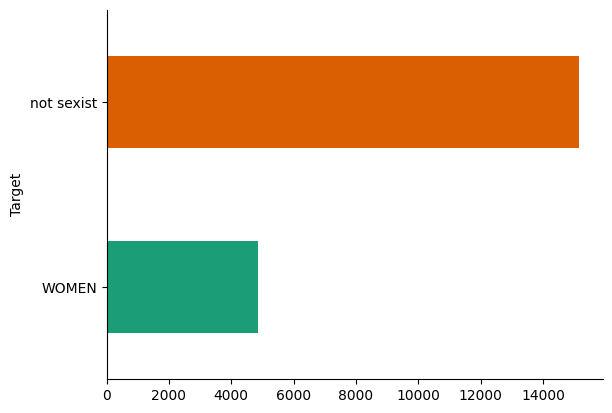

In [29]:
from matplotlib import pyplot as plt
import seaborn as sns
df_EDOS.groupby('Target').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

### SBIC - Social Bias Frame


In [30]:
def split_SBIC(df):
  tuple_head=[]
  for index,row in df.iterrows():
    tuple_temp=[row['post']]
    if "women" in row['targetMinority']:
      tuple_temp.append('sexist')
    else:
      tuple_temp.append('not sexist')
    tuple_head.append(tuple_temp)
  return pd.DataFrame(tuple_head,columns=['text','labels'])

In [31]:
raw_SBIC_train = pd.read_csv(SBIC_train_dir)
raw_SBIC_val = pd.read_csv(SBIC_val_dir)
raw_SBIC_test = pd.read_csv(SBIC_test_dir)

In [32]:
raw_SBIC_train

,Unnamed: 0,post,targetMinority,targetCategory,targetStereotype,whoTarget,intentYN,sexYN,offensiveYN,dataSource,hasBiasedImplication
0,0,"\n\nBill Kristol and Ben Shaprio, two turds in...",[],[],[],0.0,0.886667,0.0,1.000000,Gab,1
1,1,\n\nRose\n🌹Taylor‏ @RealRoseTaylor 6h6 hours a...,[],[],[],NaN,0.220000,0.0,0.000000,Gab,1
2,2,\nCharlie Kirk‏\n\nJohnny Depp calls for death...,"[""liberals""]","[""social""]","[""miscontrue things"", ""take things in a weird ...",1.0,1.000000,0.0,1.000000,Gab,0
3,3,\nDavid Knight‏ \n\nNotice how quickly things ...,[],[],[],0.0,0.110000,0.0,0.166667,Gab,1
4,4,\nFinland fireball: Time-lapse video shows nig...,[],[],[],NaN,0.000000,0.0,0.000000,Gab,1
...,...,...,...,...,...,...,...,...,...,...,...
35419,35498,👉 Illegally in the country after 5 deportation...,[],[],[],NaN,0.220000,0.0,0.000000,Gab,1
35420,35500,💥Breaking💥\nJulian Assange is the gate keeper ...,[],[],[],0.0,0.000000,0.0,0.000000,Gab,1
35421,35501,📖 2Kings 22:19 because your heart was peniten...,[],[],[],NaN,0.000000,0.0,0.000000,Gab,1
35422,35502,🚨#FAKENEWSAWARDS🚨\n\n🚨 who is #1 fake news ?🚨\...,[],[],[],0.0,0.553333,0.0,0.500000,Gab,1


In [33]:
target_minorities = set()
for target in raw_SBIC_train['targetMinority']:
  if isinstance(target, str):
    targets = target.replace('[', '').replace(']', '').replace('"', '').split(',')
    for t in targets:
      t = t.strip()
      if t:
        target_minorities.add(t)

unique_target_minorities = list(target_minorities)
for item in unique_target_minorities:
  print(item)
len(unique_target_minorities)

Middle eastern folks
Israel folks
Violent crime victims
aborted children
American Southerners
all non-white folks
all gay people
redneck
Korea
death
japanese folks
orphans
blondes
Turks
Muslim Women
indian
Minorities in general
Vegans
rich folks
Jamaican
teen moms
trans people
smokers
Police shooting victim
palistinians
alt-right
aboriginal
anorexics
everyone
Cancer victims
seniors
bisexual folks
Italians
England
syrian folks
Southerners
syrian
holocaust survivors
people with OCD
Ukrainians
Hebrew
Syrians
polish  people
Jamaicans
catholics
Saudis
Armenians
cancer patients
UK people
Socialists
israeli folks
any no white
Emo folks
roma people
Whites
gays
pro-life advocates
white folks who act black
Germans
Israel
Mexicans
middle aged men
syria
Portuguese folks
HIV positive
genital mutilation victims
ethiopia
Democratic Republic of Congo
people involved in police brutality
Sexual assault victim.
somalia
dominican women
sexual abuse
prisoners
Alzheimer patients
health related tragedy victi

1017

In [34]:
SBIC_train = split_SBIC(raw_SBIC_train)
SBIC_val = split_SBIC(raw_SBIC_val)
SBIC_test = split_SBIC(raw_SBIC_test)

In [35]:
SBIC_train

,text,labels
0,"\n\nBill Kristol and Ben Shaprio, two turds in...",not sexist
1,\n\nRose\n🌹Taylor‏ @RealRoseTaylor 6h6 hours a...,not sexist
2,\nCharlie Kirk‏\n\nJohnny Depp calls for death...,not sexist
3,\nDavid Knight‏ \n\nNotice how quickly things ...,not sexist
4,\nFinland fireball: Time-lapse video shows nig...,not sexist
...,...,...
35419,👉 Illegally in the country after 5 deportation...,not sexist
35420,💥Breaking💥\nJulian Assange is the gate keeper ...,not sexist
35421,📖 2Kings 22:19 because your heart was peniten...,not sexist
35422,🚨#FAKENEWSAWARDS🚨\n\n🚨 who is #1 fake news ?🚨\...,not sexist


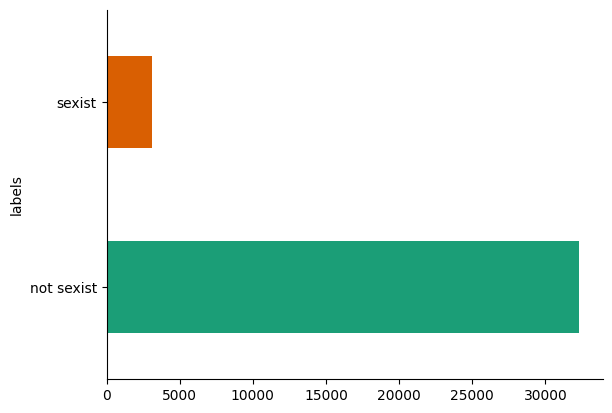

In [36]:
from matplotlib import pyplot as plt
import seaborn as sns
SBIC_train.groupby('labels').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

### CrowdCounter Benchmark


In [37]:
# Function to replace targets
def replace_CC(x):
  if x in ["Men", "Economic", "Minority", "Nonreligious", "Other", "Christian"]:
    return "other"

  elif x in ["Hindu", "Caucasian", "Indian", "Arab", "Indigenous", "African", "Asian", "Hispanic"]:
    return "POC"

  elif x == "Disability":
    return "DISABLED"

  elif x == "Islam":
    return "MUSLIMS"

  elif x == "Women":
    return "WOMEN"

  elif x in ["Homosexual", "Asexual", "Heterosexual"]:
    return "LGBT+"

  elif x == "Jewish":
    return "JEWS"

  elif x == "Refugee":
    return "MIGRANTS"

  elif x == [] or x == '':
    return np.nan

  else:
    return x

# Function to create hate-counter pairs
def separate_hate_counter_pairs(df):
  """
  Separates hate post and counter speech pairs into individual instances.

  Args:
    df: A pandas DataFrame containing hate post and counter speech pairs.

  Returns:
    A new pandas DataFrame with individual instances of hate post and counter speech pairs.
  """
  new_rows = []
  for index, row in df.iterrows():
    hate_post = row['post']
    targets = row['targets']
    if isinstance(row['counterspeech_post'], dict):
      for worker_id, counterspeech in row['counterspeech_post'].items():
        new_rows.append({'Hate_Speech': hate_post, 'Counter_Speech': counterspeech['counterspeech'], 'Target': targets})
    else:
      # Handle cases where counterspeech_post is not a dictionary (e.g., a single string)
      new_rows.append({'Hate_Speech': hate_post, 'Counter_Speech': row['counterspeech_post'], 'Target': targets})

  return pd.DataFrame(new_rows)


In [38]:
raw_CC = pd.read_json(CrowdCounter_dir).T

In [39]:
raw_CC["targets"] = [ list(set(list(map(replace_CC, x)))) for x in raw_CC["targets"]]
df_CC = separate_hate_counter_pairs(raw_CC)

In [40]:
df_CC

,Hate_Speech,Counter_Speech,Target
0,I try be nice but i ain't gon let no mudshark ...,It must be hard to feel like you are misunders...,"[POC, MUSLIMS, LGBT+]"
1,I try be nice but i ain't gon let no mudshark ...,Why so much hate for?,"[POC, MUSLIMS, LGBT+]"
2,I probably ended up another kike list somewher...,"Wow, I never knew you could spew so much hatre...",[JEWS]
3,I probably ended up another kike list somewher...,this can be considered anti-Semitic,[JEWS]
4,I hope he ends up being raped legally...and th...,"Rape is a horrific thing to happen to someone,...",[other]
...,...,...,...
3430,GB turned into an faggoty and muzzie Orwellian...,I understand that you have some strong feeling...,"[MUSLIMS, LGBT+]"
3431,GB turned into an faggoty and muzzie Orwellian...,Using hate speech and calling for lynching wil...,"[MUSLIMS, LGBT+]"
3432,Don't even talk to this nigger @user you don't...,"Well, definitely not everyone - such things ar...","[POC, other, LGBT+]"
3433,Don't even talk to this nigger @user you don't...,I am sure you have had a bad experience in the...,"[POC, other, LGBT+]"


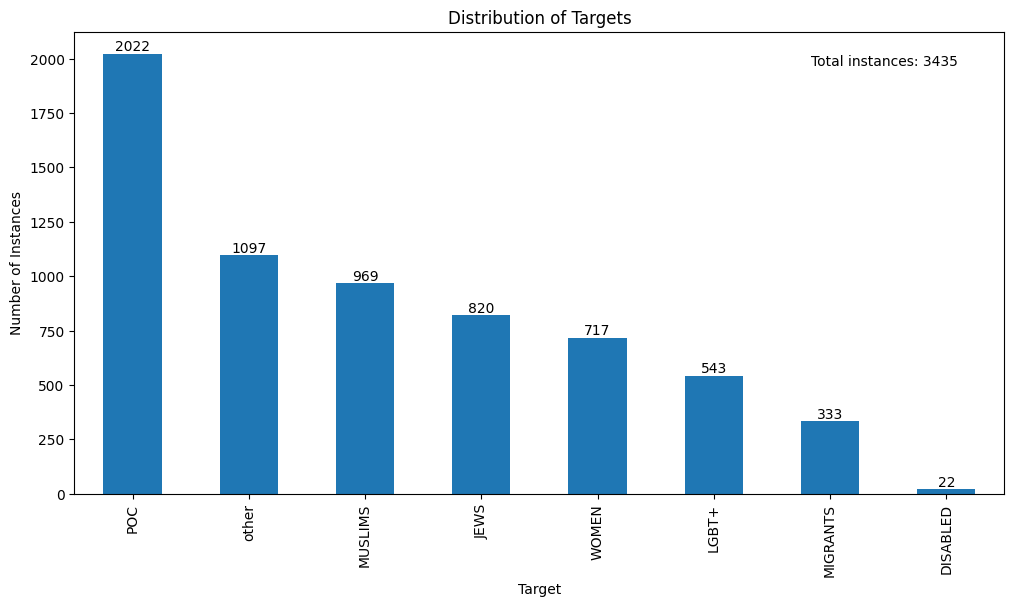

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# Flatten the list of targets into a single column
target_counts = pd.DataFrame({'Target': [target for sublist in df_CC['Target'] for target in sublist]})

# Group by target and count occurrences
target_distribution = target_counts.groupby('Target')['Target'].count().sort_values(ascending=False)

# Create a bar chart with counts on each bar
plt.figure(figsize=(12, 6))
ax = target_distribution.plot(kind='bar')
ax.set_xlabel('Target')
ax.set_ylabel('Number of Instances')
ax.set_title('Distribution of Targets')

# Add count labels to each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Add total number of instances as a label
plt.text(0.95, 0.95, f"Total instances: {len(df_CC)}", transform=plt.gca().transAxes, ha='right', va='top')

plt.show()

## Create Training datasets for Counter-Speech Generator
---

<br>

for training counter-speech generators, we include dataset that contains hate- and counter-speech pairs.
1. df_Qian_gab
2. df_Qian_reddit
3. df_CONAN
4. df_MultiCONAN
5. df_DIALOCONAN
6. df_KNCONAN
7. df_CC


In [49]:
# Concatenate dataframes for better parallelization
select_dataframes = ['CONAN', 'Multi_CONAN', 'DIALO_CONAN', 'KN_CONAN', 'CrowdCounter']

df_Generator = pd.concat(
    [df_CONAN, df_MultiCONAN, df_DIALOCONAN, df_KNCONAN, df_CC],
    keys=select_dataframes,
    names=['Dataset', 'Row ID'],
    sort=False)

In [50]:
df_Generator

Hate_Speech  \
Dataset      Row ID                                                      
CONAN        0       According to a recent OFSTED report, a school ...   
             1       In Birmingham there is a school where girls an...   
             2       A school in Birningham is still separating gir...   
             3       According to a recent OFSTED report, a school ...   
             4       In Birmingham there is a school where girls an...   
...                                                                ...   
CrowdCounter 3430    GB turned into an faggoty and muzzie Orwellian...   
             3431    GB turned into an faggoty and muzzie Orwellian...   
             3432    Don't even talk to this nigger @user you don't...   
             3433    Don't even talk to this nigger @user you don't...   
             3434    Don't even talk to this nigger @user you don't...   

                                                        Counter_Speech  \
Dataset      Row ID                                                      
CONAN        0       To be fair, the OFSTED report is more concerne...   
             1       To be fair, the OFSTED report is more concerne...   
             2       To be fair, the OFSTED report is more concerne...   
             3       While this story is presented as an 'Islamic i...   
             4       While this story is presented as an 'Islamic i...   
...                                                                ...   
CrowdCounter 3430    I understand that you have some strong feeling...   
             3431    Using hate speech and calling for lynching wil...   
             3432    Well, definitely not everyone - such things ar...   
             3433    I am sure you have had a bad experience in the...   
             3434    If you don't understand what a term means, may...   

                                  Target knowledge_sentence  
Dataset      Row ID                                          
CONAN        0                 [MUSLIMS]                NaN  
             1                 [MUSLIMS]                NaN  
             2                 [MUSLIMS]                NaN  
             3                 [MUSLIMS]                NaN  
             4                 [MUSLIMS]                NaN  
...                                  ...                ...  
CrowdCounter 3430       [MUSLIMS, LGBT+]                NaN  
             3431       [MUSLIMS, LGBT+]                NaN  
             3432    [POC, other, LGBT+]                NaN  
             3433    [POC, other, LGBT+]                NaN  
             3434    [POC, other, LGBT+]                NaN  

[20806 rows x 4 columns]

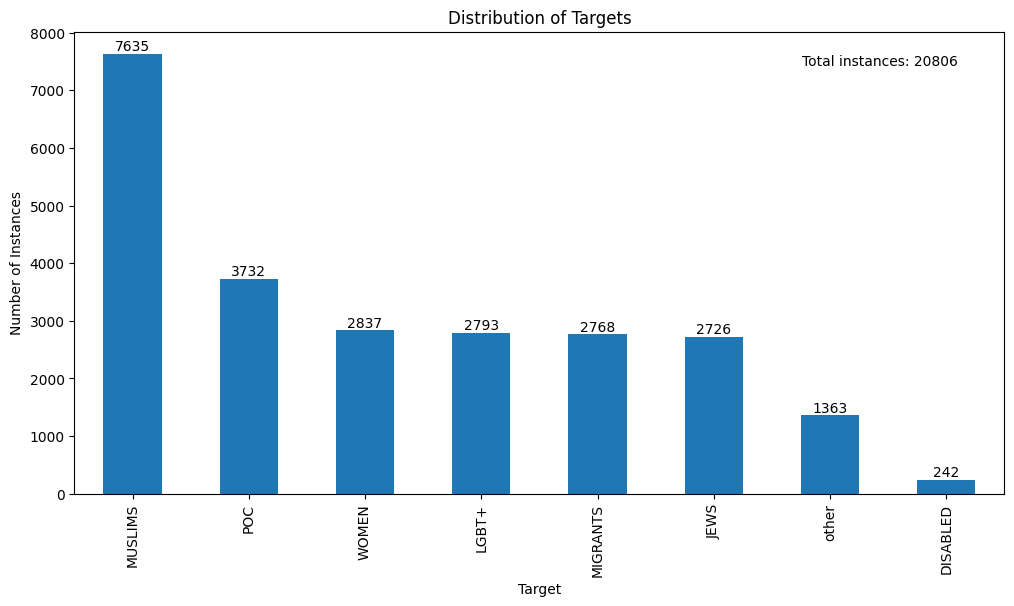

In [51]:
# Flatten the list of targets into a single column
target_counts = pd.DataFrame({'Target': [target if isinstance(target, str) else 'NaN' for sublist in df_Generator['Target'] for target in (sublist if isinstance(sublist, list) else [sublist])]})

# Group by target and count occurrences
target_distribution = target_counts.groupby('Target')['Target'].count().sort_values(ascending=False)

# Create a bar chart with counts on each bar
plt.figure(figsize=(12, 6))

ax = target_distribution.plot(kind='bar')
ax.set_xlabel('Target')
ax.set_ylabel('Number of Instances')
ax.set_title('Distribution of Targets')

# Add count labels to each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Add total number of instances as a label
plt.text(0.95, 0.95, f"Total instances: {len(df_Generator)}", transform=plt.gca().transAxes, ha='right', va='top')

plt.show()

## Create Training datasets for Topic Classifier
---

<br>

for training topic classifier, we include dataset that contains hate- and counter-speech pairs.
1. df_CONAN
2. df_MultiCONAN
3. df_DIALOCONAN
4. df_KNCONAN
5. df_CC
6. df_EDOS_sexist
7. SBIC?


In [52]:
# Concatenate dataframes for better parallelization
select_dataframes = ['CrowdCounter', 'CONAN', 'Multi_CONAN', 'DIALO_CONAN', 'KN_CONAN', 'EDOS_Sexist']

df_Topic_Classifier = pd.concat(
    [df_CC, df_CONAN, df_MultiCONAN, df_DIALOCONAN, df_KNCONAN, df_EDOS_sexist],
    keys=select_dataframes,
    names=['Dataset', 'Row ID'],
    sort=False)

# Drop instances without target label
df_Topic_Classifier = df_Topic_Classifier[df_Topic_Classifier['Target'].map(len) > 0]

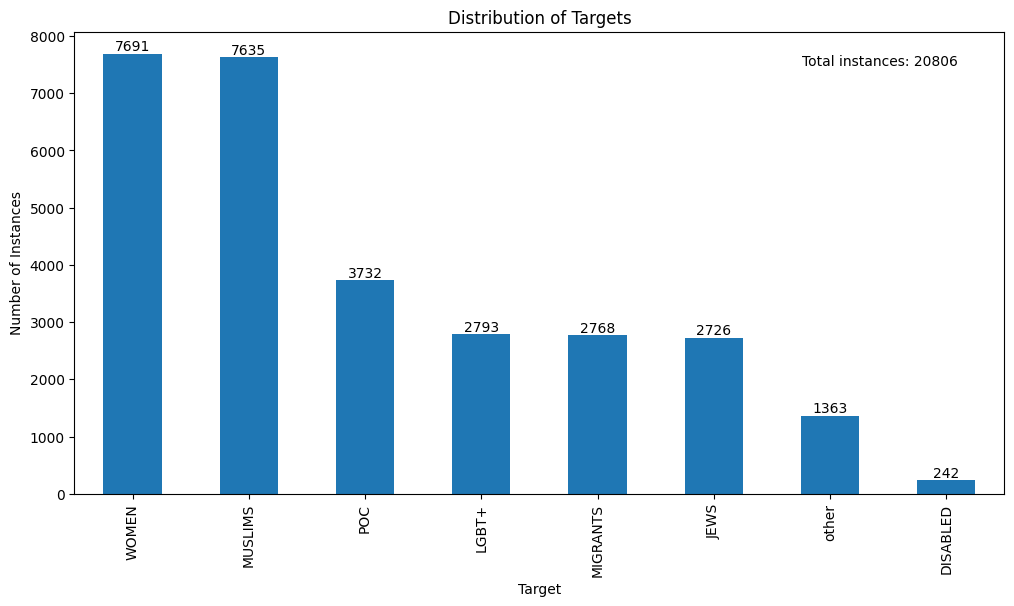

In [56]:
# Flatten the list of targets into a single column
target_counts = pd.DataFrame({'Target': [target if isinstance(target, str) else 'NaN' for sublist in df_Topic_Classifier['Target'] for target in (sublist if isinstance(sublist, list) else [sublist])]})

# Group by target and count occurrences
target_distribution = target_counts.groupby('Target')['Target'].count().sort_values(ascending=False)

# Create a bar chart with counts on each bar
plt.figure(figsize=(12, 6))

ax = target_distribution.plot(kind='bar')
ax.set_xlabel('Target')
ax.set_ylabel('Number of Instances')
ax.set_title('Distribution of Targets')

# Add count labels to each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Add total number of instances as a label
plt.text(0.95, 0.95, f"Total instances: {len(df_Generator)}", transform=plt.gca().transAxes, ha='right', va='top')

plt.show()

In [54]:
# Convert labels into multiclass labels where each class is individually annotated with either 0 or 1
for target in types:
  df_Topic_Classifier[target] = df_Topic_Classifier["Target"].apply(lambda x: 1 if target in x else 0)

In [55]:
df_Topic_Classifier

Hate_Speech  \
Dataset      Row ID                                                      
CrowdCounter 0       I try be nice but i ain't gon let no mudshark ...   
             1       I try be nice but i ain't gon let no mudshark ...   
             2       I probably ended up another kike list somewher...   
             3       I probably ended up another kike list somewher...   
             4       I hope he ends up being raped legally...and th...   
...                                                                ...   
EDOS_Sexist  19983   This is easily the dumbest thing ever written....   
             19984   Recently some thots started advertizing their ...   
             19986   I wish yall understand what a burden it can be...   
             19992   idiocracy always seems to be female. Best evid...   
             19999       this bi--th should be stoped she's the rapist   

                                                        Counter_Speech  \
Dataset      Row ID                                                      
CrowdCounter 0       It must be hard to feel like you are misunders...   
             1                                   Why so much hate for?   
             2       Wow, I never knew you could spew so much hatre...   
             3                     this can be considered anti-Semitic   
             4       Rape is a horrific thing to happen to someone,...   
...                                                                ...   
EDOS_Sexist  19983                                                 NaN   
             19984                                                 NaN   
             19986                                                 NaN   
             19992                                                 NaN   
             19999                                                 NaN   

                                    Target knowledge_sentence  MIGRANTS  POC  \
Dataset      Row ID                                                            
CrowdCounter 0       [POC, MUSLIMS, LGBT+]                NaN         0    1   
             1       [POC, MUSLIMS, LGBT+]                NaN         0    1   
             2                      [JEWS]                NaN         0    0   
             3                      [JEWS]                NaN         0    0   
             4                     [other]                NaN         0    0   
...                                    ...                ...       ...  ...   
EDOS_Sexist  19983                 [WOMEN]                NaN         0    0   
             19984                 [WOMEN]                NaN         0    0   
             19986                 [WOMEN]                NaN         0    0   
             19992                 [WOMEN]                NaN         0    0   
             19999                 [WOMEN]                NaN         0    0   

                     LGBT+  MUSLIMS  WOMEN  JEWS  other  DISABLED  
Dataset      Row ID                                                
CrowdCounter 0           1        1      0     0      0         0  
             1           1        1      0     0      0         0  
             2           0        0      0     1      0         0  
             3           0        0      0     1      0         0  
             4           0        0      0     0      1         0  
...                    ...      ...    ...   ...    ...       ...  
EDOS_Sexist  19983       0        0      1     0      0         0  
             19984       0        0      1     0      0         0  
             19986       0        0      1     0      0         0  
             19992       0        0      1     0      0         0  
             19999       0        0      1     0      0         0  

[25639 rows x 12 columns]

from matplotlib import pyplot as plt
df_Topic_Classifier['MIGRANTS'].plot(kind='hist', bins=20, title='MIGRANTS')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_Topic_Classifier['POC'].plot(kind='hist', bins=20, title='POC')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_Topic_Classifier['LGBT+'].plot(kind='hist', bins=20, title='LGBT+')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_Topic_Classifier['MUSLIMS'].plot(kind='hist', bins=20, title='MUSLIMS')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_Topic_Classifier.plot(kind='scatter', x='MIGRANTS', y='POC', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_Topic_Classifier.plot(kind='scatter', x='POC', y='LGBT+', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_Topic_Classifier.plot(kind='scatter', x='LGBT+', y='MUSLIMS', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_Topic_Classifier.plot(kind='scatter', x='MUSLIMS', y='WOMEN', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_Topic_Classifier['MIGRANTS'].plot(kind='line', figsize=(8, 4), title='MIGRANTS')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_Topic_Classifier['POC'].plot(kind='line', figsize=(8, 4), title='POC')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_Topic_Classifier['LGBT+'].plot(kind='line', figsize=(8, 4), title='LGBT+')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_Topic_Classifier['MUSLIMS'].plot(kind='line', figsize=(8, 4), title='MUSLIMS')
plt.gca().spines[['top', 'right']].set_visible(False)

## Data Cleaning
For fine-tuning GPT models (Causal Language Modeling), we concatenate the hate speech and the counter speech in one string with each begins with their prefix:
### **Hate-speech: "Text" Counter-speech: "Text"**

---

In [59]:
import math
import preprocessor as p

# set options for cleaning text data (convert URLs and Emojis into special tokens $URL$, $EMJ$ )
p.set_options(p.OPT.URL, p.OPT.EMOJI)

def clean(item):
  # Text cleaning function, removes URLs, EMOJIs and extra whitespaces or special characters
  if isinstance(item, str):
    item = p.tokenize(item)

  return item

In [60]:
df_Topic_Classifier['Hate_Speech'] = df_Topic_Classifier['Hate_Speech'].map(clean)
df_Topic_Classifier['Counter_Speech'] = df_Topic_Classifier['Counter_Speech'].map(clean)
df_Generator['Hate_Speech'] = df_Generator['Hate_Speech'].map(clean)
df_Generator['Counter_Speech'] = df_Generator['Counter_Speech'].map(clean)

# Save dataframe to csv for future usage

In [61]:
save_dir = os.path.join(data_dir, 'Custom_New/')
G_name = "Generator_train.csv"
C_name = "Classifier_train.csv"

os.makedirs(save_dir, exist_ok=True)
df_Topic_Classifier.to_csv(save_dir + C_name)
df_Generator.to_csv(save_dir + G_name)